# Analysis of results with `MiniGridEnv`

This notebook explores and visualize the results on `MiniGridEnv` adopting different strategies:
1. random action policy
2. market-only policy
3. battery-first policy
4. 20/80 policy
5. 50/50 policy
6. training a PPO agent with StableBaselines3 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/Users/dave/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Repositories/ernesto-gym


/Users/dave/miniconda3/envs/ernesto-gym/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from pathlib import Path

from ernestogym.envs import MicroGridEnv
from ernestogym.envs.single_agent.utils import parameter_generator

sns.set_style('darkgrid')
plot_colors = sns.color_palette()
sns.set(font_scale=1.5)

plots_dir = 'examples/single_agent/plots'
os.makedirs(plots_dir, exist_ok=True)

In [200]:
#folder = "./logs/fading/"
folder = "./logs/fading_norm_weights_trained_clip/"
#exp_type = 'scaled_gen_07_015'
exp_type = 'clip_09_005'

do_not_save = False

In [201]:
result_files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

In [202]:
result_files

['a2c.json',
 'battery_first.json',
 '20-80.json',
 'random.json',
 'ppo.json',
 '50-50.json',
 'only_market.json']

In [203]:
df_results = {file.split('.')[0]: pd.read_json(Path(folder, file)) for file in result_files}

In [204]:
policy_names = [file.split('.')[0] for file in result_files]

In [205]:
df_results['ppo']

,pure_reward,actual_reward,weighted_reward,total_reward
70,"[[-0.0006207080000000001, 0.0, 0, 0.0], [-0.00...","[[-0.2816493257, 0.0, 0, 0.0], [-0.2816493257,...","[[-0.2534843931, 0.0, 0, 0.0], [-0.2534843931,...",-140567.409429
71,"[[-0.008252595, 0.0, 0, 0.0], [-0.0053561638, ...","[[-0.3206085504, 0.0, 0, 0.0], [-0.3058228605,...","[[-0.2885476954, 0.0, 0, 0.0], [-0.2752405744,...",-135653.343333
72,"[[-0.007547245, 0.0, 0, 0.0], [-0.0070264545, ...","[[-0.3170078827, 0.0, 0, 0.0], [-0.31434935340...","[[-0.2853070945, 0.0, 0, 0.0], [-0.282914418, ...",-135817.937597
73,"[[-0.004048709, 0.0, 0, 0.0], [-0.003470322, 0...","[[-0.2991485708, 0.0, 0, 0.0], [-0.2961960233,...","[[-0.2692337137, 0.0, 0, 0.0], [-0.266576421, ...",-134459.247067
74,"[[-0.003230503, 0.0, 0, 0.0], [-0.003230503, 0...","[[-0.29497179630000003, 0.0, 0, 0.0], [-0.2949...","[[-0.2654746166, 0.0, 0, 0.0], [-0.2654746166,...",-134605.525288


## Methods for plots

In [206]:
pack_options = "ernestogym/ernesto/data/battery/pack.yaml"
ecm = "ernestogym/ernesto/data/battery/models/electrical/thevenin_pack.yaml"
# ecm = "ernestogym/ernesto/data/battery/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto/data/battery/models/thermal/r2c_thermal_pack.yaml"
bolun = "ernestogym/ernesto/data/battery/models/aging/bolun_pack.yaml"
world = "ernestogym/envs/single_agent/world_deg.yaml"
# world = "ernestogym/envs/single_agent/world_fading.yaml"

params = parameter_generator(
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
)

# Create environment
env = MicroGridEnv(settings=params)

timestamps = env.demand.timestamps

test_profiles = ['70', '71', '72', '73', '74']

In [207]:
from datetime import datetime
timestamps = [datetime.strptime(time, "%Y-%m-%d %H:%M:%S") for time in timestamps]

In [208]:
policy_names

['a2c', 'battery_first', '20-80', 'random', 'ppo', '50-50', 'only_market']

In [209]:
def get_clean_data(data_dict):
    results = {test: {'trading': [], 'op_cost': [], 'clip': []} for test in test_profiles}
    
    for test in test_profiles:
        results[test]['trading'] = [data_dict[int(test)][i][0] for i in range(len(data_dict[int(test)]))]
        results[test]['op_cost'] = [data_dict[int(test)][i][1] for i in range(len(data_dict[int(test)]))]
        results[test]['clip'] = [data_dict[int(test)][i][3] for i in range(len(data_dict[int(test)]))]

    return results

In [210]:
alg_names = {
    'a2c': 'A2C',
    'battery_first': 'Battery-first',
    '20-80': '20-80',
    'random': 'Random',
    'ppo': 'PPO',
    '50-50': '50-50',
    'only_market': 'Only-market',
    'ppo2': 'PPO'
    
}

In [211]:
weighted_dict = {}
actual_dict = {}
pure_dict = {}
total_reward_dict = {}

for alg in policy_names:
    weighted_dict[alg_names[alg]] = get_clean_data(df_results[alg]['weighted_reward'])
    actual_dict[alg_names[alg]] = get_clean_data(df_results[alg]['actual_reward'])
    #pure_dict[alg] = get_clean_data(df_results[alg]['pure_reward'])
    total_reward_dict[alg_names[alg]] = [df_results[alg]['total_reward'][int(test)] for test in test_profiles]

In [212]:
def get_mean_list(data: dict):
    """
    Pass dict of alg already filtered and structured as {test: list of stuff}
    """
    mean_list = [np.mean([data[test][i] for test in test_profiles]) for i in range(len(data['70']))]
    return mean_list

In [213]:
def get_std_list(data: dict):
    """
    Pass dict of alg already filtered
    """
    std_list = [np.std([data[test][i] for test in test_profiles]) for i in range(len(data['70']))]
    return std_list

In [214]:
def savefig(fig: plt.Figure, filename: str, **kwargs) -> None:
    if not do_not_save:
        save_path = os.path.join(plots_dir, filename)
        fig.savefig(save_path, dpi=300, bbox_inches='tight', **kwargs)

In [215]:
def average_return():
    data = total_reward_dict
    
    fig, ax = plt.subplots(figsize=(9, 5), tight_layout=True)
    sns.boxplot(data, gap=.1)
    
    print({key: np.mean(values) for key, values in total_reward_dict.items()})
    
    savefig(fig, filename='average_return_{}.pdf'.format(exp_type))
    savefig(fig, filename='average_return_{}.png'.format(exp_type))
        

def average_step_reward_comparison(sampling_rate=50, dict_type='weighted', test_id=None):
    data = None
    
    if dict_type == 'weighted':
        data = weighted_dict
    elif dict_type == 'actual':
        data = actual_dict
    else: 
        data = pure_dict
    
    fig, ax = plt.subplots(figsize=(9, 5), tight_layout=True)
    
    for i, item in enumerate(data.items()):
        key, values = item
        
        if key in ['a2c', 'ppo2']:

            sum_dict = {}

            for test in test_profiles:
                sum_dict[test] = [a+b+c for a,b,c in zip(data[key][test]['trading'], data[key][test]['op_cost'], data[key][test]['clip'])]

            mean_list = get_mean_list(sum_dict)
            std_list = get_std_list(sum_dict)

            std_neg = [mean - std / len(mean_list)**2 for mean, std in zip(mean_list, std_list)]
            std_pos = [mean + 0.9 * std / len(mean_list)**2 for mean, std in zip(mean_list, std_list)]

            ax.plot(timestamps[::sampling_rate], mean_list[::sampling_rate], label=key, color=plot_colors[i])
            ax.fill_between(timestamps[::sampling_rate], std_neg[::sampling_rate], std_pos[::sampling_rate], color=plot_colors[i], alpha=0.5)
            ax.set(xlabel='Time', ylabel='Cumulative Reward', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 
    ax.legend()

def cum_average_reward_terms_comparison(sampling_rate=50, dict_type='weighted'):
    data = None
    
    if dict_type == 'weighted':
        data = weighted_dict
    elif dict_type == 'actual':
        data = actual_dict
    else: 
        data = pure_dict
    
    fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(9, 12), tight_layout=True)
    
    for i, item in enumerate(data.items()):
        key, values = item
        
        trad_dict = {}
        op_cost_dict = {}
        clip_dict = {}

        for test in test_profiles:
            trad_dict[test] = [a for a in data[key][test]['trading']]
            op_cost_dict[test] = [b for b in data[key][test]['op_cost']]
            clip_dict[test] = [c for c in data[key][test]['clip']]
            
        trad_mean_list = get_mean_list(trad_dict)
        #trad_std_list = get_std_list(trad_dict)
        op_cost_mean_list = get_mean_list(op_cost_dict)
        #op_cost_std_list = get_std_list(op_cost_dict)
        clip_mean_list = get_mean_list(clip_dict)
        #clip_std_list = get_std_list(clip_dict)
        
        ax1.plot(timestamps[::sampling_rate], np.cumsum(trad_mean_list)[::sampling_rate], label=key, color=plot_colors[i])
        ax1.set(xlabel='Time', ylabel='Avg. Trading Reward', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]])         
        ax1.legend()
        
        ax2.plot(timestamps[::sampling_rate], np.cumsum(op_cost_mean_list)[::sampling_rate], label=key, color=plot_colors[i])
        ax2.set(xlabel='Time', ylabel='Avg. Operational Cost', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 
        ax2.legend()
        
        ax3.plot(timestamps[::sampling_rate], np.cumsum(clip_mean_list)[::sampling_rate], label=key, color=plot_colors[i])
        ax3.set(xlabel='Time', ylabel='Avg. Action Clipping', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 
        ax3.legend()
        
    savefig(fig, filename='cum_average_trading_term{}_{}.pdf'.format(exp_type, dict_type))
    savefig(fig, filename='cum_average_trading_term{}_{}.png'.format(exp_type, dict_type))
    
    
def single_policy_plot_rewards_terms(dict_type, policy='ppo'):
    nrows = 3
    ncols = 1
    labels = ['Trading', 'Operational Cost', 'Action_clipping']
    
    data = None
    
    if dict_type == 'weighted':
        data = weighted_dict
    elif dict_type == 'actual':
        data = actual_dict
    else: 
        data = pure_dict
    
    values = data[policy]['70']
    
    fig, ax = plt.subplots(nrows, ncols, figsize=(8, 12), tight_layout=True, sharex=True)
    
    for j, key in enumerate(values.keys()):
        ax[j].plot(timestamps, values[key], label='{} Reward'.format(labels[j]), color=plot_colors[j])
        ax[j].set(xlabel='Time', ylabel='{} Reward'.format(labels[j]), 
                  xticks=[timestamps[0], timestamps[len(timestamps)//2],timestamps[-1]])
        #ax[j].legend()

{'A2C': -136230.709588199, 'Battery-first': -135375.94722777442, '20-80': -135745.79308394695, 'Random': -135102.2010268669, 'PPO': -136220.69254264847, '50-50': -135583.60461617302, 'Only-market': -136230.709588199}


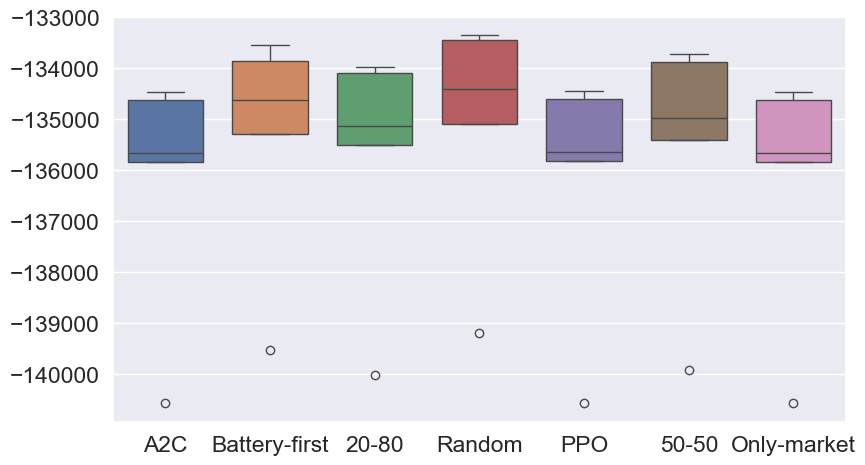

In [216]:
average_return()

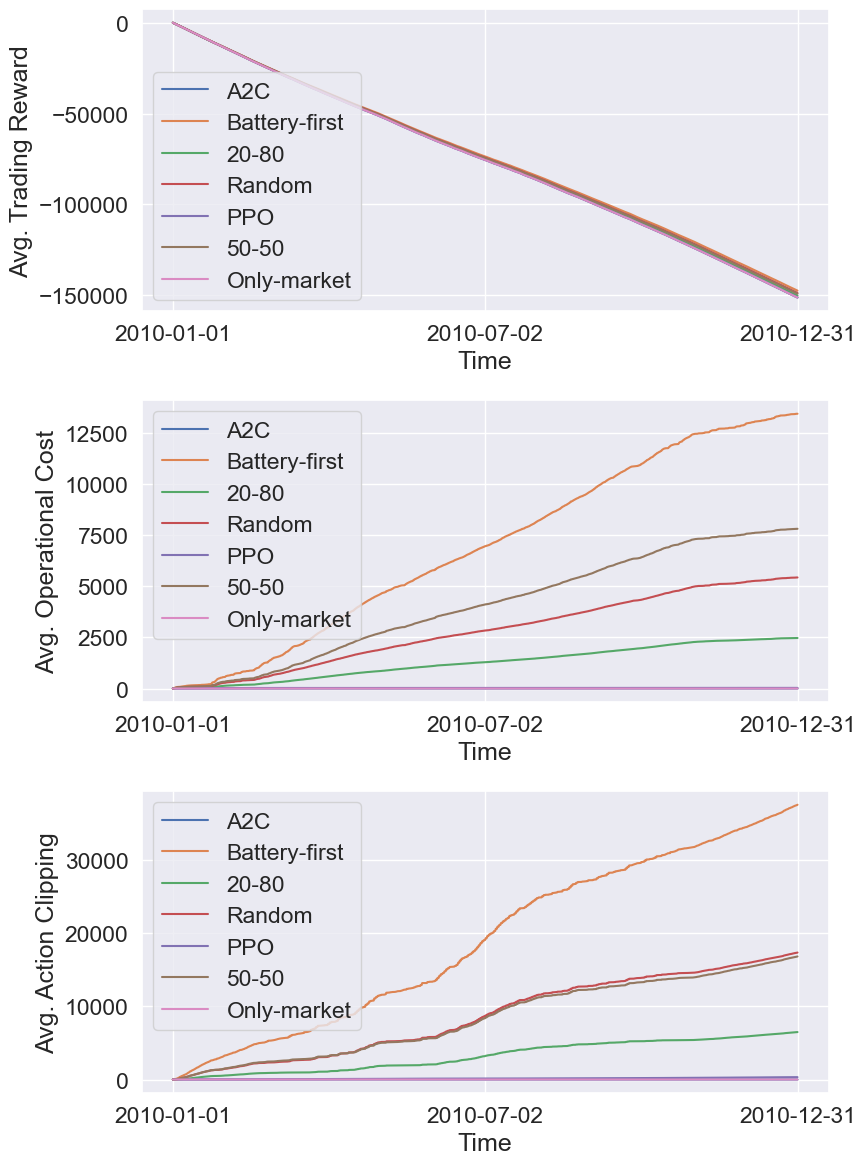

In [217]:
cum_average_reward_terms_comparison(dict_type='actual')

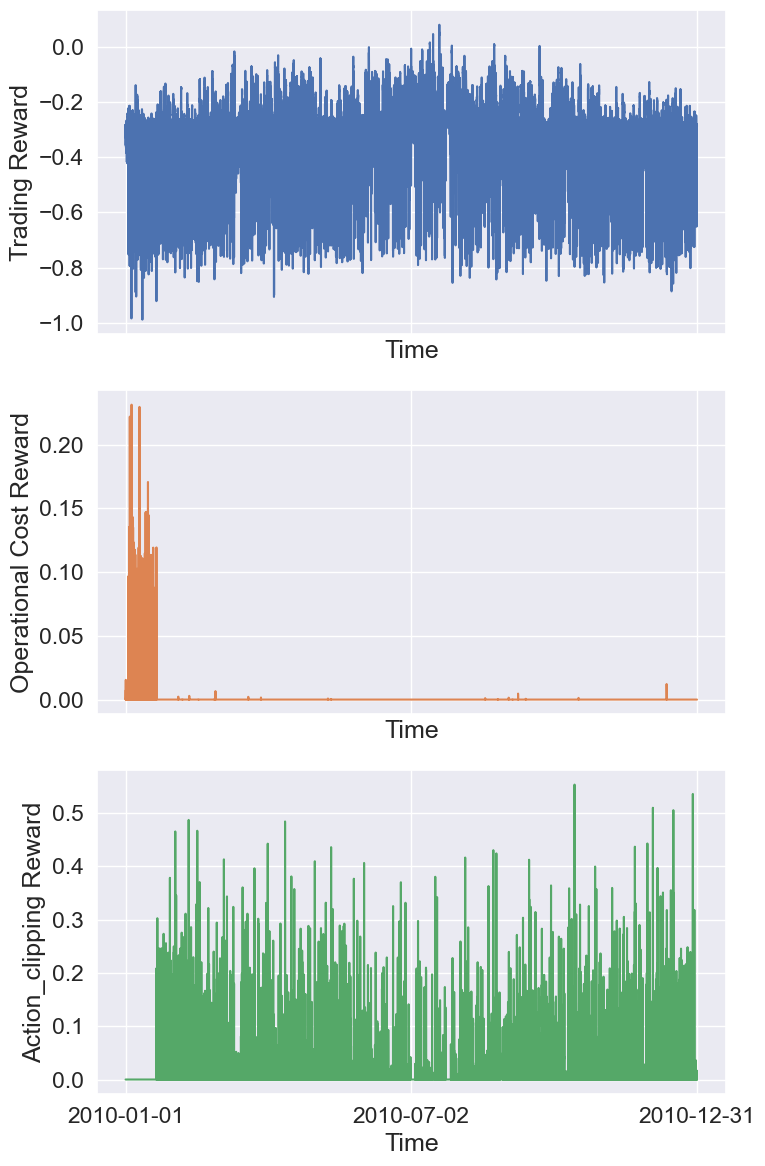

In [218]:
single_policy_plot_rewards_terms(policy='PPO', dict_type='actual')

## Test Environments
We can imagine 3 different scenarios:
1. The energy price is raising and we prefere to use stored energy 
2. The replacement cost of batteries is increased and we prefer to limit its usage and rather trade with the market
3. We want to keep an average profile that and stay in the middle

For the above scenarios we can think to maximize a reward function with the following weigths:
1. r_trad * 0.9 + r_op * 0.1 -> in this way we penalize less for the battery usage
2. r_trad * 0.1 + r_op * 0.9 -> in this way we penalize less for the market usage
3. r_trad * 0.5 + r_op * 0.5 -> both market and usage have the same weight